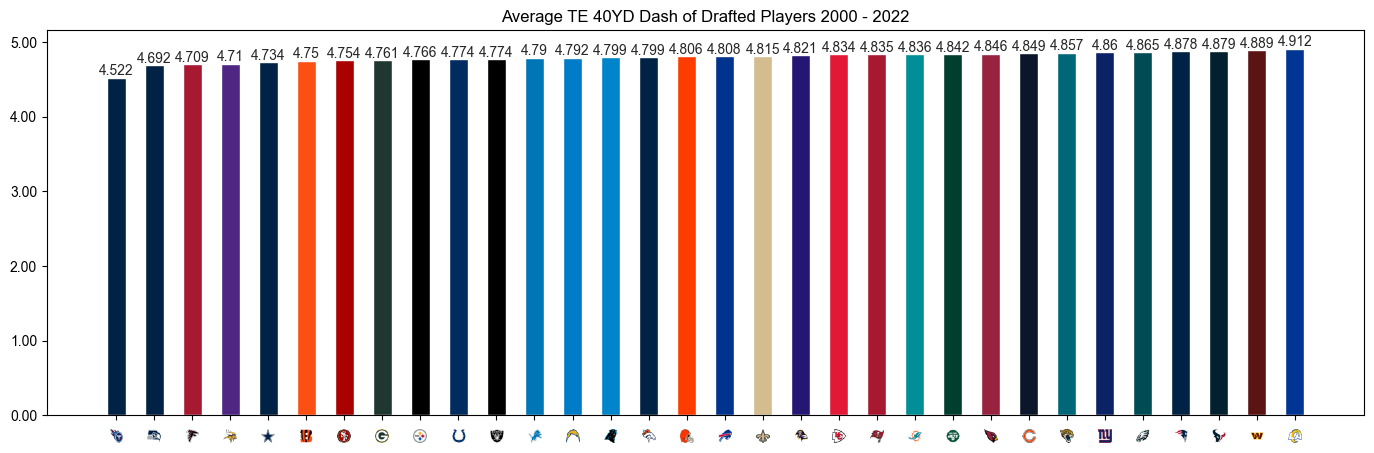

In [1]:
# Imports
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage,AnnotationBbox
from matplotlib.ticker import FormatStrFormatter
import PIL
from PIL import Image
import urllib

# Setting up / cleaning initial data frames (df) 
df_combine = pd.read_csv('https://raw.githubusercontent.com/fantasydatapros/LearnPythonWithFantasyFootball/master/2023/07-Data%20Visualizations/02-Combine%20Data%202000%20to%202023.csv')
df_combine = df_combine.drop(['PFRPlayerID', 'CFBPlayerID'], axis=1)
df_combine = df_combine.rename({'DraftOverallPick`': 'DraftOverallPick'}, axis=1)

df_style = pd.read_csv('https://raw.githubusercontent.com/nflverse/nflverse-pbp/master/teams_colors_logos.csv')


# Setting up / cleaning drafted players df
df_drafted = df_combine[df_combine['DraftTeam'].notna()]
df_drafted = df_drafted.replace({
    'DraftTeam': {
        'Washington Football Team': 'Washington Commanders',
        'Washington Redskins': 'Washington Commanders',
        'Oakland Raiders': 'Las Vegas Raiders',
        'St. Louis Rams': 'Los Angeles Rams',
        'San Diego Chargers': 'Los Angeles Chargers'
    }
})

# Get stat / position dfs by filtering drafted player df for stat / position to analyze
df_drafted_POS = df_drafted.loc[df_drafted['Pos'] == 'QB']

df_STAT = df_drafted_POS.groupby('DraftTeam', as_index=False).agg({
    '40YD': np.mean
}).sort_values(by='40YD', ignore_index=True)

# Get xy plotting arrays 
teams = df_STAT['DraftTeam'].to_numpy()
stat = df_STAT['40YD'].to_numpy()

# Get colors for bar plots
colors = {}

for team in teams:    
    color = df_style.loc[df_style['team_name'] == f'{team}', 'team_color'].values[0]
    
    colors[f'{team}'] = f'{color}'
    
colors = list(colors.values())

# Get logos for bar plot annotations
logos = {}

for _, row in df_style.iterrows():
    
    name = row['team_name']
    logo = row['team_logo_wikipedia']
    
    logos[f'{name}'] = f'{logo}'
    
logos['Washington Commanders'] = 'https://a.espncdn.com/i/teamlogos/nfl/500/wsh.png'

# Define functions 
def get_logo(name):
    
    path = logos[f'{name}']
    im = np.array(PIL.Image.open(urllib.request.urlopen(path)).resize((20, 20)))
    return im

def offset_image(coord, name, ax):
    img = get_logo(name)
    im = OffsetImage(img, zoom=1)
    im.image.axes = ax

    ab = AnnotationBbox(im, (coord, 0),  xybox=(0., -15.), frameon=False,
                        xycoords='data',  boxcoords="offset points", pad=0)

    ax.add_artist(ab)

# Plot graph
fig, ax = plt.subplots()

sns.set_style('whitegrid')

ax.bar(range(len(teams)), sorted(stat), width=0.5 ,align='center', color=colors)
ax.set_xticks(range(len(teams)))
ax.tick_params(axis='x', which='major', pad=26)
ax.set_title('Average TE 40YD Dash of Drafted Players 2000 - 2022')
ax.set(xticklabels=[]) 
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.grid(False)

for p in ax.patches:
    ax.annotate(str(round(float(p.get_height()), 3)), (p.get_x() + p.get_width() / 2., p.get_height()-0.1), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

fig.set_figwidth(17)
fig.set_figheight(5)

for i, c in enumerate(teams):
    offset_image(i, c, ax)
    
plt.show()